In [1]:
import sys
import itertools
import types
from collections import OrderedDict

import seaborn

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class GaussianMixture:
  def __init__(self, count: int, std=0.02, radius=2.0):
    self.count = count
    self.std = std
    self.radius = radius
    angles = torch.arange(0, 2*np.pi, 2*np.pi/count, out=torch.FloatTensor())
    self.centers = torch.stack([radius * torch.sin(angles), radius * torch.cos(angles)], dim=1)

  def sample(self, batch_size: int):
    distrib = torch.distributions.Categorical(torch.ones((1, self.count), dtype=torch.float32))
    center_idx = distrib.sample((batch_size,)).squeeze()
    sample = torch.FloatTensor(batch_size, 2).normal_() * self.std + self.centers[center_idx]
    return sample

In [3]:
batch_size = 512
latent_dim = 128
hidden_dim = 256

In [4]:
class Generator(nn.Module):
  def __init__(self, latent_dim, hidden_dim):
    super(Generator, self).__init__()
    self.body = nn.Sequential(OrderedDict([
      ('fc1', nn.Linear(latent_dim, hidden_dim)),
      ('relu', nn.ReLU()),
      ('fc2', nn.Linear(hidden_dim, 2))
    ]))
  
  def forward(self, x):
    return self.body(x)

class Discriminator(nn.Module):
  def __init__(self, hidden_dim):
    super(Discriminator, self).__init__()
    self.body = nn.Sequential(OrderedDict([
      ('fc1', nn.Linear(2, hidden_dim)),
      ('relu', nn.ReLU()),
      ('fc2', nn.Linear(hidden_dim, 1))
    ]))

  def forward(self, x):
    return self.body(x)


generator = Generator(latent_dim, hidden_dim)
discriminator = Discriminator(hidden_dim)
generator.cuda()
discriminator.cuda()
d_optim = torch.optim.Adam(discriminator.parameters(), lr=1e-3)
g_optim = torch.optim.Adam(generator.parameters(), lr=1e-3)

As discussed in the tutorial exercise, the GAN loss can also be expressed as binary cross entropy with labels 1 for true samples and labels 0 for fake samples. We can use that to compute the loss criterion more conveniently in PyTorch: 

In [13]:
def train(
    generator: nn.Module, 
    discriminator: nn.Module, 
    g_optim: optim.Optimizer, 
    d_optim: optim.Optimizer, 
    batch_size=512, 
    latent_dim=128,
    max_iter=5000, 
    plot_every=100,
    cuda=True
    ):
  
  mixture = GaussianMixture(8)
  criterion = nn.BCEWithLogitsLoss()
  if cuda:
    generator, discriminator = generator.cuda(), discriminator.cuda()

  for i in range(max_iter):
      noise = torch.FloatTensor(batch_size, latent_dim).normal_()
      real_data = mixture.sample(batch_size)
      if cuda:
        noise, real_data = noise.cuda(), real_data.cuda()
      
      # Discriminator update
      generator.eval()
      discriminator.train()

      d_optim.zero_grad()

      # Measure discriminator's ability to classify real from generated samples
      real_out = discriminator(real_data)
      fake_out = discriminator(generator(noise))
      real_loss = criterion(real_out, torch.ones([batch_size,1]).cuda())
      fake_loss = criterion(fake_out, torch.zeros([batch_size,1]).cuda())
      d_loss = (real_loss + fake_loss) / 2

      d_loss.backward()
      d_optim.step()

      # Generator Update
      generator.train()
      discriminator.eval()

      g_optim.zero_grad()

      # Generate a batch of images
      gen_imgs = generator(noise)
      
      # Loss measures generator's ability to fool the discriminator
      g_loss = criterion(discriminator(gen_imgs), torch.ones([batch_size,1]).cuda())

      g_loss.backward()
      g_optim.step()

      #Plot data:
      if i % plot_every == 0:
          xx_real = real_data.data.cpu().numpy()
          
          generator.eval()
          noise = torch.FloatTensor(batch_size*10, latent_dim).normal_()
          if cuda:
            noise = noise.cuda()

          fake_data = generator(noise)
          fake_data_cpu = fake_data.data.cpu().numpy()
          xx_fake = fake_data.data.cpu().numpy()
          
          sys.stdout.write(f'\rStep: {i}/{max_iter} D loss: {d_loss:.6f} G loss: {-g_loss:.6f}')

          fig, ax = plt.subplots(1, 2, figsize=(10,5))
          ax[0].scatter(xx_fake[:, 0], xx_fake[:, 1], edgecolor='w',alpha=0.6)
          ax[0].scatter(xx_real[:, 0], xx_real[:, 1], c='g', edgecolor='w', alpha=0.6)
          seaborn.kdeplot(x=fake_data_cpu[:, 0], y=fake_data_cpu[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-2.5,2.5]]*2, ax=ax[1])
          plt.show()

Step: 0/5000 D loss: 0.658079 G loss: -0.702259

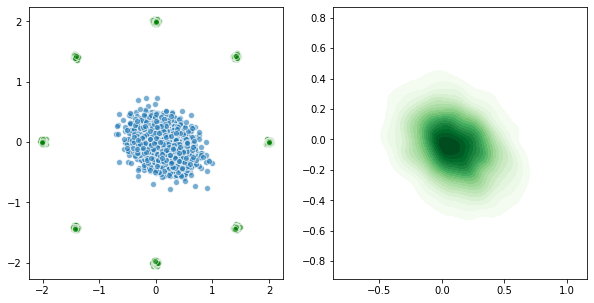

Step: 100/5000 D loss: 0.572253 G loss: -1.736814

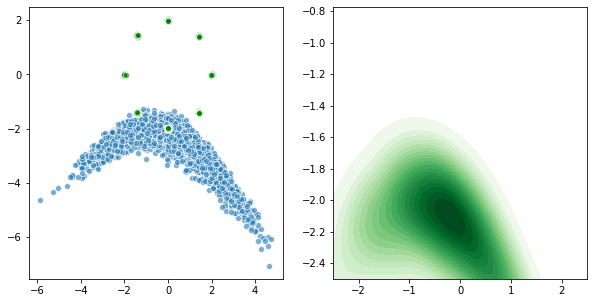

Step: 200/5000 D loss: 0.609538 G loss: -1.098763

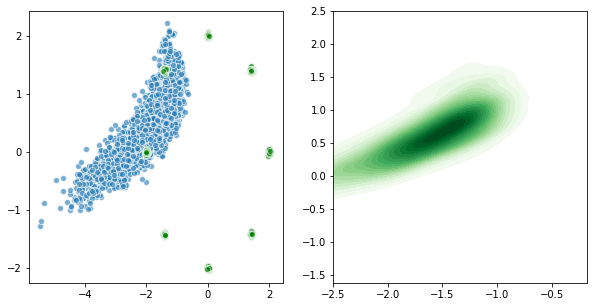

Step: 300/5000 D loss: 0.672263 G loss: -0.898873

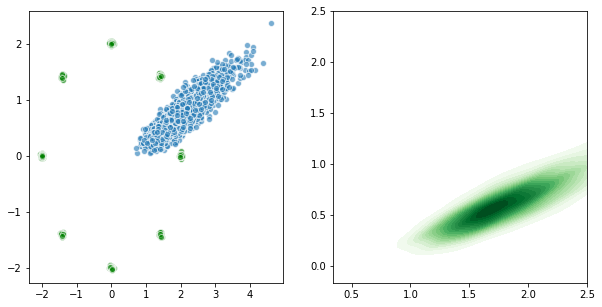

Step: 400/5000 D loss: 0.793254 G loss: -0.712332

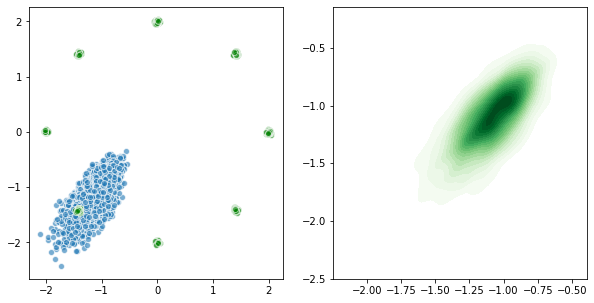

Step: 500/5000 D loss: 0.646427 G loss: -0.841196

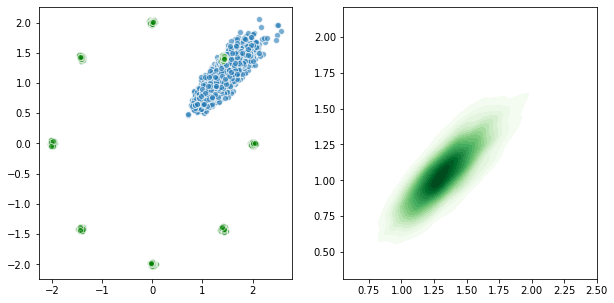

Step: 600/5000 D loss: 0.707339 G loss: -0.901972

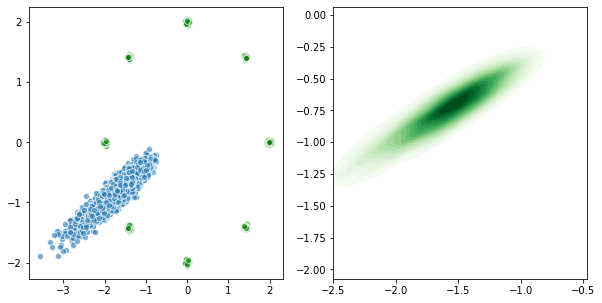

Step: 700/5000 D loss: 0.640363 G loss: -0.923044

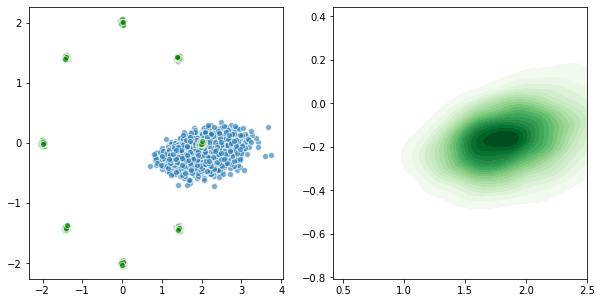

Step: 800/5000 D loss: 0.580503 G loss: -0.918319

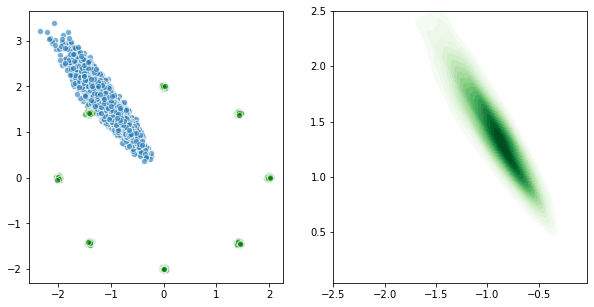

Step: 900/5000 D loss: 0.663659 G loss: -0.987205

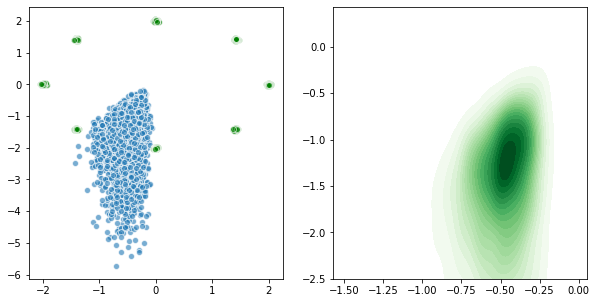

Step: 1000/5000 D loss: 0.569800 G loss: -1.068960

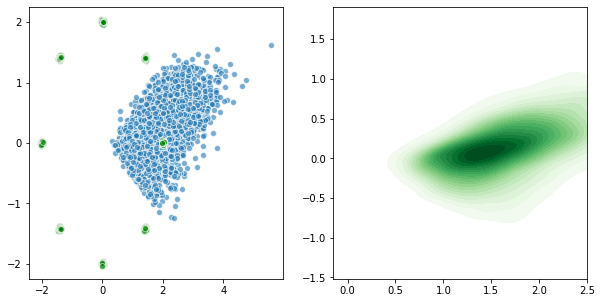

Step: 1100/5000 D loss: 0.592597 G loss: -0.956620

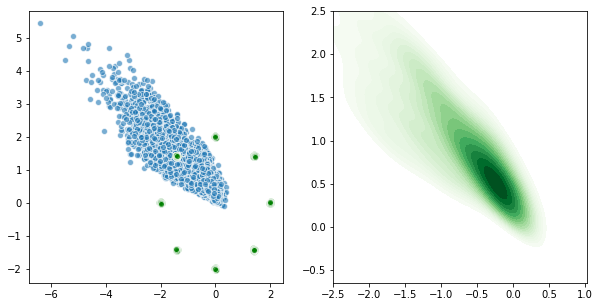

Step: 1200/5000 D loss: 0.601383 G loss: -0.948146

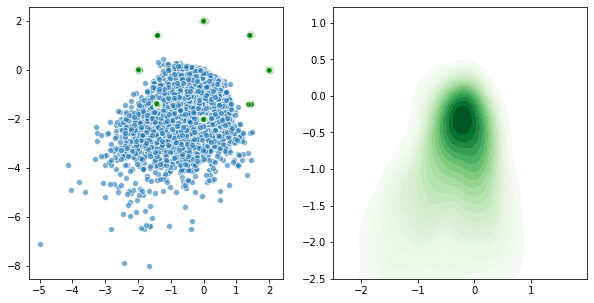

Step: 1300/5000 D loss: 0.448423 G loss: -1.067377

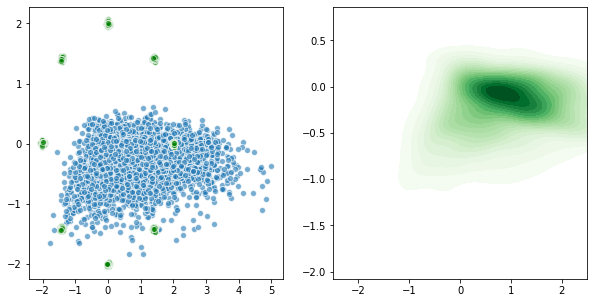

Step: 1400/5000 D loss: 0.610154 G loss: -1.071540

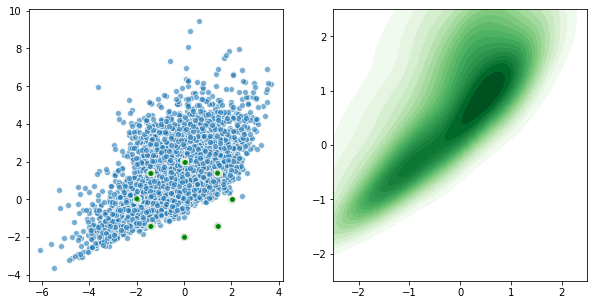

Step: 1500/5000 D loss: 0.615456 G loss: -0.892323

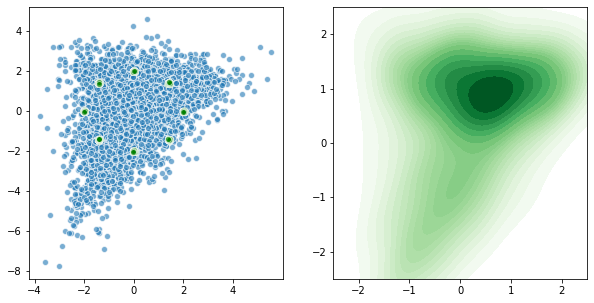

Step: 1600/5000 D loss: 0.558448 G loss: -0.885288

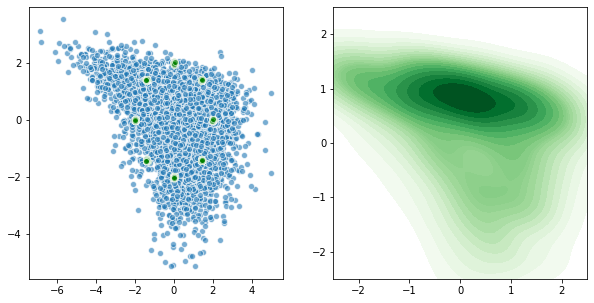

Step: 1700/5000 D loss: 0.559732 G loss: -0.916167

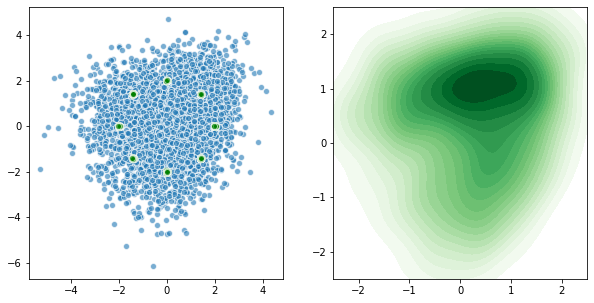

Step: 1800/5000 D loss: 0.558427 G loss: -0.902868

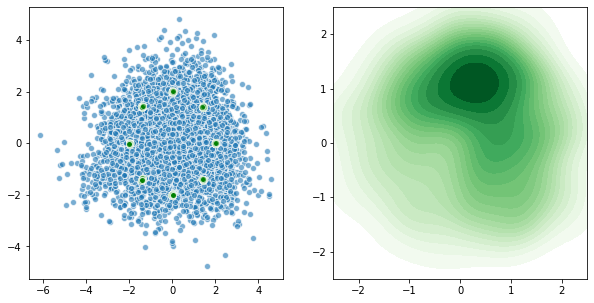

Step: 1900/5000 D loss: 0.541413 G loss: -0.936739

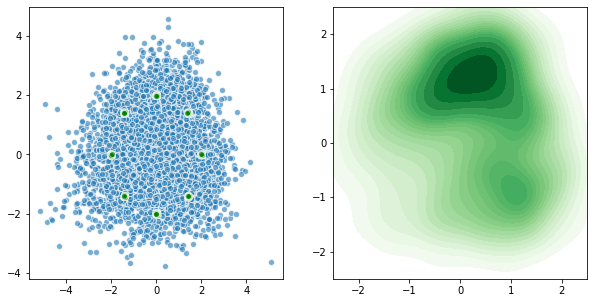

Step: 2000/5000 D loss: 0.537852 G loss: -0.946028

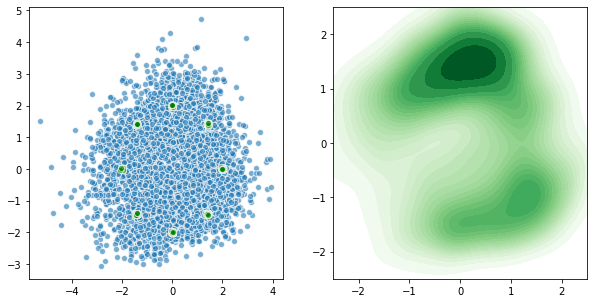

Step: 2100/5000 D loss: 0.538272 G loss: -0.968542

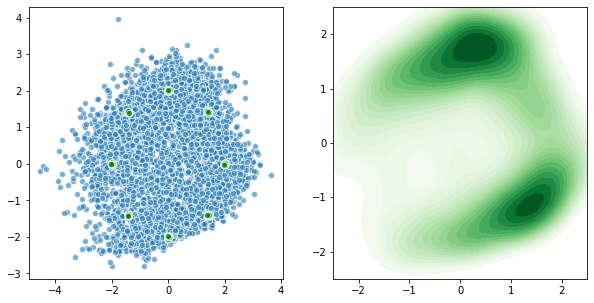

Step: 2200/5000 D loss: 0.558163 G loss: -0.917212

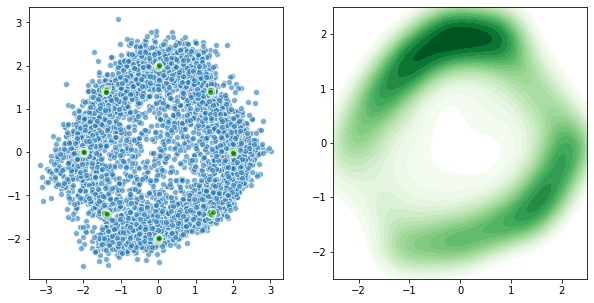

Step: 2300/5000 D loss: 0.572393 G loss: -0.897735

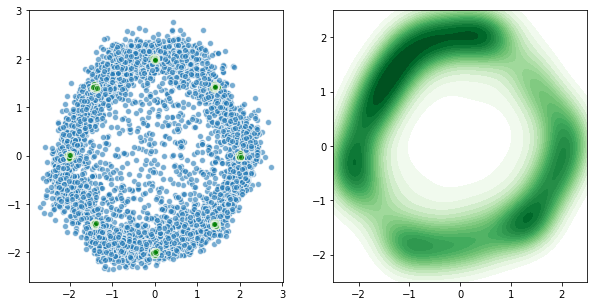

Step: 2400/5000 D loss: 0.573600 G loss: -0.882231

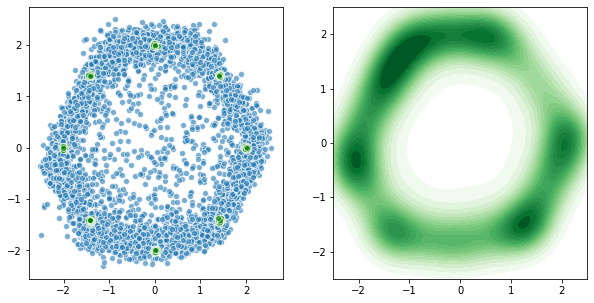

Step: 2500/5000 D loss: 0.575725 G loss: -0.861411

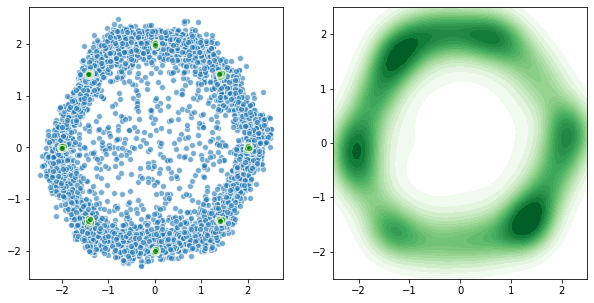

Step: 2600/5000 D loss: 0.577434 G loss: -0.869535

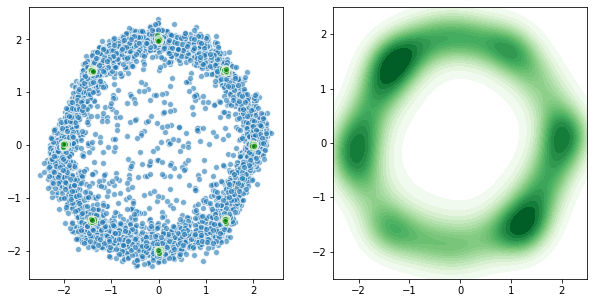

Step: 2700/5000 D loss: 0.581900 G loss: -0.870825

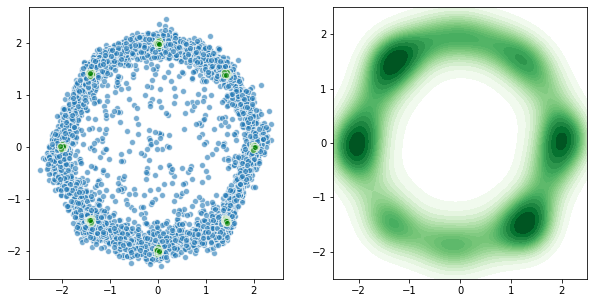

Step: 2800/5000 D loss: 0.582527 G loss: -0.879436

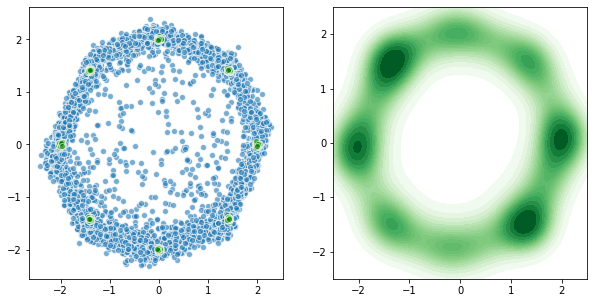

Step: 2900/5000 D loss: 0.591926 G loss: -0.869754

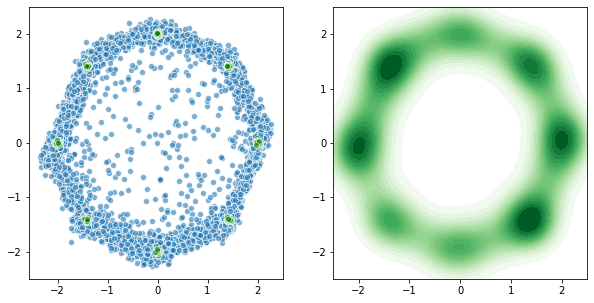

Step: 3000/5000 D loss: 0.592622 G loss: -0.866438

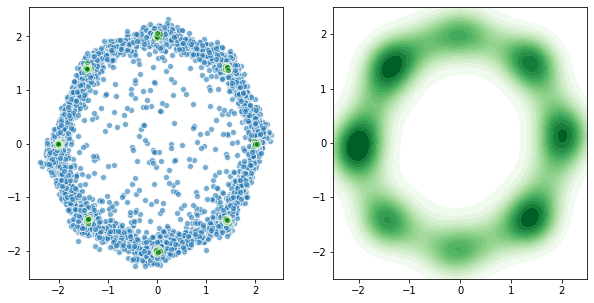

Step: 3100/5000 D loss: 0.585197 G loss: -0.868738

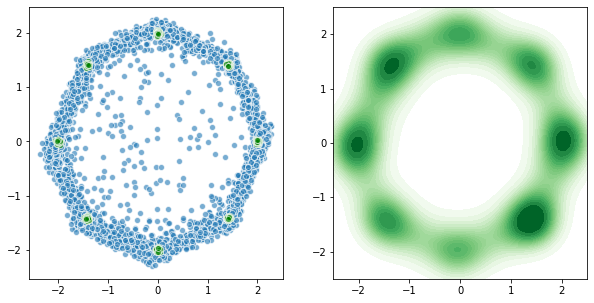

Step: 3200/5000 D loss: 0.592026 G loss: -0.864847

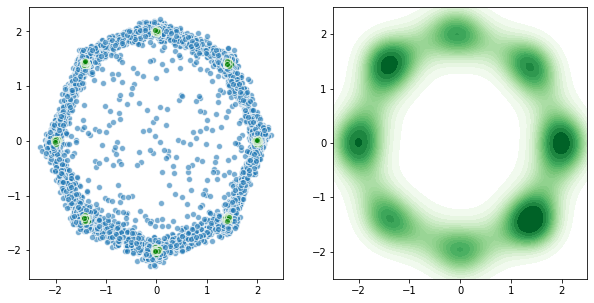

Step: 3300/5000 D loss: 0.590187 G loss: -0.868313

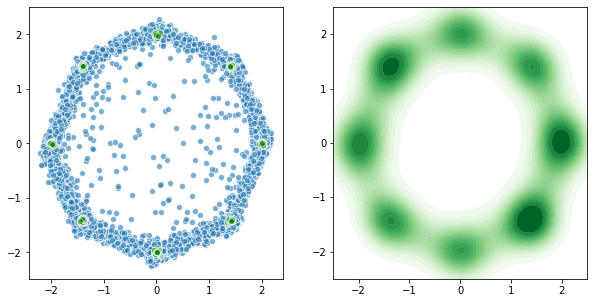

Step: 3400/5000 D loss: 0.586369 G loss: -0.893856

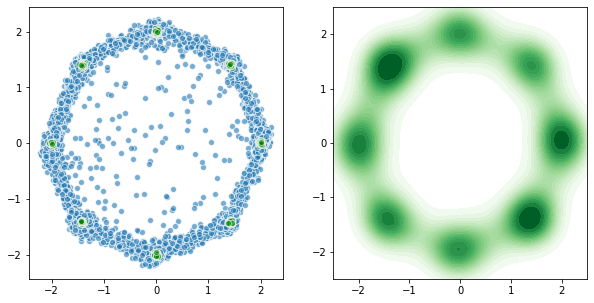

Step: 3500/5000 D loss: 0.584386 G loss: -0.901328

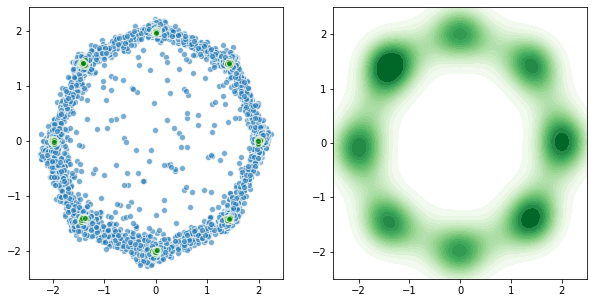

Step: 3600/5000 D loss: 0.596113 G loss: -0.848470

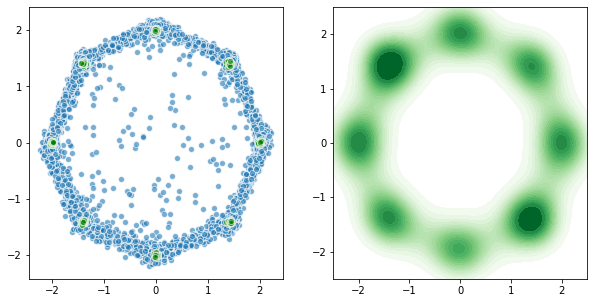

Step: 3700/5000 D loss: 0.599828 G loss: -0.830548

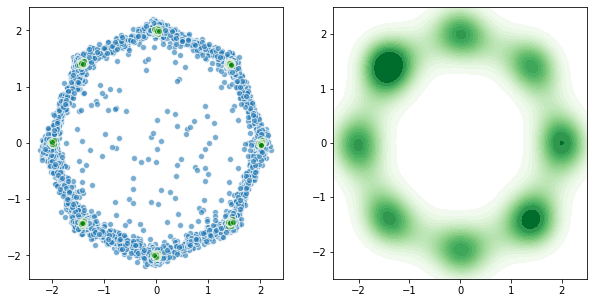

Step: 3800/5000 D loss: 0.592199 G loss: -0.887273

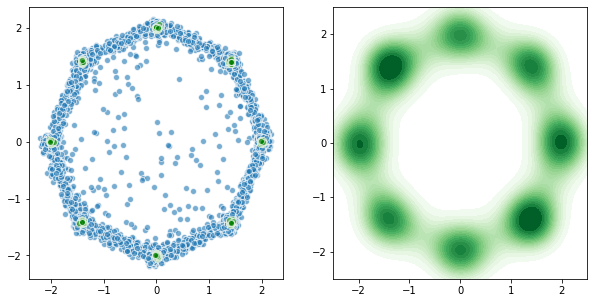

Step: 3900/5000 D loss: 0.594871 G loss: -0.887183

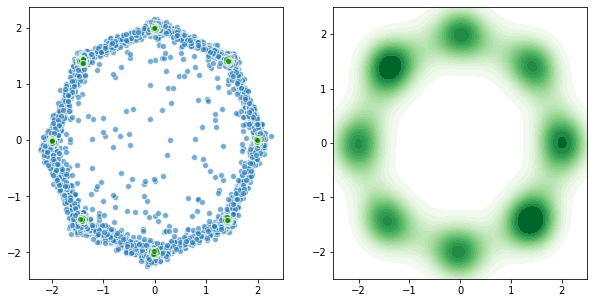

Step: 4000/5000 D loss: 0.591509 G loss: -0.907086

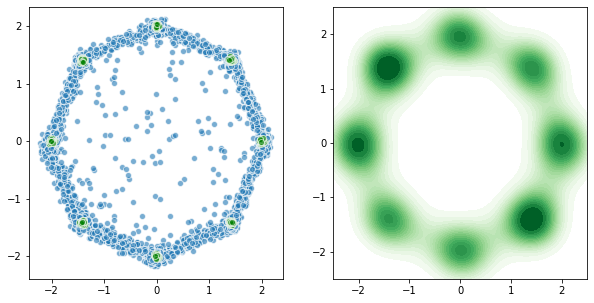

Step: 4100/5000 D loss: 0.597912 G loss: -0.852186

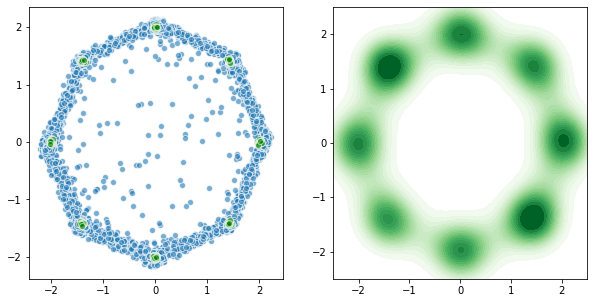

Step: 4200/5000 D loss: 0.590078 G loss: -0.903072

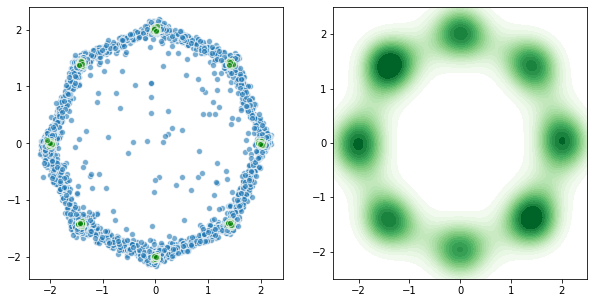

Step: 4300/5000 D loss: 0.590888 G loss: -0.927369

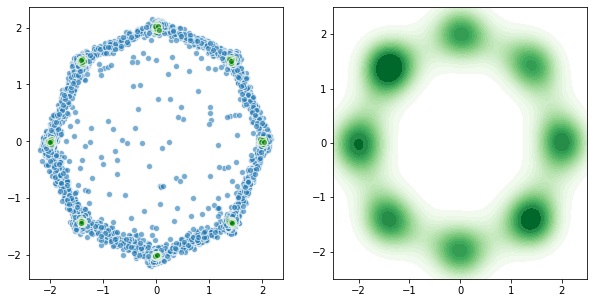

Step: 4400/5000 D loss: 0.600570 G loss: -0.906928

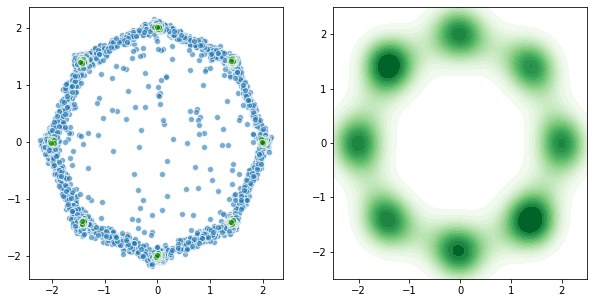

Step: 4500/5000 D loss: 0.600734 G loss: -0.872752

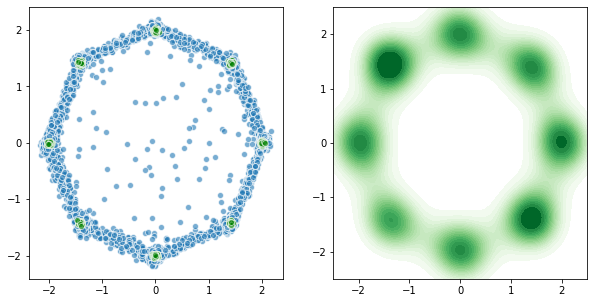

Step: 4600/5000 D loss: 0.600272 G loss: -0.952989

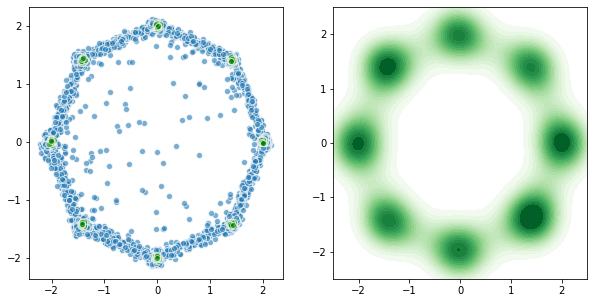

Step: 4700/5000 D loss: 0.594872 G loss: -0.894336

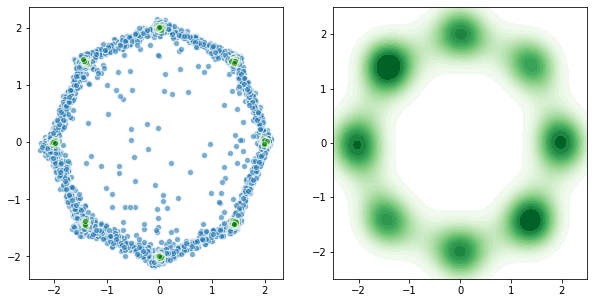

Step: 4800/5000 D loss: 0.590814 G loss: -0.933660

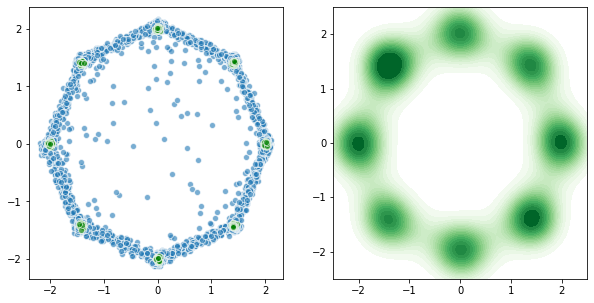

Step: 4900/5000 D loss: 0.594123 G loss: -0.956723

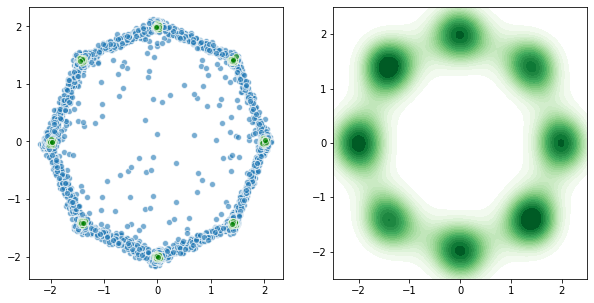

In [14]:
train(generator, discriminator, g_optim, d_optim, max_iter=5000, plot_every=100, latent_dim=latent_dim, cuda=True)